In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import pandas as pd
import random

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam


from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.legend()

    plt.show()

def plot_resultados(model, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    imgs_reconstruidas = model.predict(imgs_originales)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def mostrar_imagenes_generadas(modelo_generador, latent_dim=100, num_imagenes=4, image_size=(64, 64, 3)):
    """
    Genera y muestra imágenes lado a lado usando un modelo generador.

    Args:
        modelo_generador: modelo Keras que recibe un vector latente y devuelve una imagen.
        latent_dim: dimensión del vector latente.
        num_imagenes: número de imágenes a generar.
        image_size: tamaño esperado de las imágenes (solo usado si quieres validar forma).
    """
    # Generar vectores latentes aleatorios
    z = generateLatentDim(latent_dim, num_imagenes)

    # Generar imágenes con el modelo
    imagenes = modelo_generador.predict(z)

    # Mostrar imágenes en una fila
    fig, axes = plt.subplots(1, num_imagenes, figsize=(num_imagenes * 3, 3))
    for i, ax in enumerate(axes):
        ax.imshow(imagenes[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def generar_imagenes(modelo_generador, latent_dim=100, num_imagenes=4):
    """
    Genera imágenes en escala de grises usando un modelo generador y OpenCV.

    Args:
        modelo_generador: modelo Keras que recibe un vector latente y devuelve una imagen.
        latent_dim: dimensión del vector latente.
        num_imagenes: número de imágenes a generar.

    Returns:
        Array de imágenes en escala de grises con forma (num_imagenes, alto, ancho).
    """
    # Generar vectores latentes aleatorios
    z = np.random.normal(0, 1, (num_imagenes, latent_dim))

    # Generar imágenes con el modelo
    imagenes_rgb = modelo_generador.predict(z)

    # Asegurar que las imágenes están en el rango [0, 255] y tipo uint8
    imagenes_rgb = (imagenes_rgb * 255).astype(np.uint8)

    # Convertir a escala de grises con OpenCV
    imagenes_grises = np.array([cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY) for imagen in imagenes_rgb])

    return imagenes_grises


# GAN

## Defining Hiperparameters

In [2]:
import os

os.listdir("/kaggle/input")

['images']

In [3]:
height, width = 64, 64 # Image size, to fit in the competition size
image_dir = '/kaggle/input'
folder = "/kaggle/working/models/10_13_14:27/"

latent_dim_size = 100
batch_size = 256

In [4]:
# Latent dim generator
def generateLatentDim(latent_dim_size=latent_dim_size, batch_size= batch_size):
    return np.random.randn(batch_size, latent_dim_size)

# Discriminator
disc_input = Input(shape=(height, width, 3)) 
x_disc = Conv2D(16, (3, 3), activation="relu", strides=1, padding="same")(disc_input)
x_disc = Conv2D(32, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = MaxPooling2D()(x_disc)
x_disc = Conv2D(64, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = Conv2D(128, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = Conv2D(256, (3, 3), activation="relu", strides=1, padding="same")(x_disc)
x_disc = Flatten()(x_disc)
x_disc = Dense(512, activation="relu")(x_disc)
x_disc = Dense(512, activation="relu")(x_disc)
classification = Dense(1, activation="sigmoid")(x_disc)

# Generator
gen_input = Input(shape=(latent_dim_size,))
x_gen = Dense(512*4*4)(gen_input)
x_gen= Reshape((4, 4, 512))(x_gen)
x_gen = Conv2DTranspose(256, (3, 3), activation="relu", strides=2, padding="same")(x_gen)
x_gen = Conv2DTranspose(128, (3, 3), activation="relu", strides=2, padding="same")(x_gen)
x_gen = Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x_gen)
x_gen = Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x_gen)
x_gen = Conv2DTranspose(16, (3, 3), activation="relu", strides=1, padding="same")(x_gen)
gen_image = Conv2DTranspose(3, (3, 3), activation="sigmoid", padding="same")(x_gen)

I0000 00:00:1760447552.065408      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


We define the autoencoder, encoder and decoder

In [8]:
if folder == None:
    generator = keras.Model(gen_input, gen_image)
    discriminator = keras.Model(disc_input, classification)
else:
    generator = keras.models.load_model(folder + "Generator.keras")
    discriminator = keras.models.load_model(folder + "Discrimiator.keras")
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 3)      │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,399,651 (9.15 MB)

 Trainable params: 2,399,651 (9.15 MB)

 Non-trainable params: 0 (0.00 B)

## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [10]:
datagen = ImageDataGenerator(rescale=1./255)

# Create training and validation generators using the same seed
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),  
    batch_size=batch_size,
    class_mode='input',
    subset='training',
    shuffle=True,
    seed=2004  
)

Found 63565 images belonging to 1 classes.


## Train

In [11]:
# Compilar discriminador con binary_crossentropy
opt_d = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
opt_g = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator.trainable = True
discriminator.compile(optimizer=opt_d, loss='binary_crossentropy', metrics=['accuracy'])

# Congelar discriminador para entrenar el generador
discriminator.trainable = False
gan_input = tf.keras.layers.Input(shape=(latent_dim_size,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer=opt_g, loss='binary_crossentropy')

I0000 00:00:1760447753.070527      94 service.cc:148] XLA service 0x7acd2c003320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760447753.071185      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760447753.159502      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760447754.323803      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0 | D loss: 0.1079 | D acc: 0.9766 | G loss: 2.4099
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


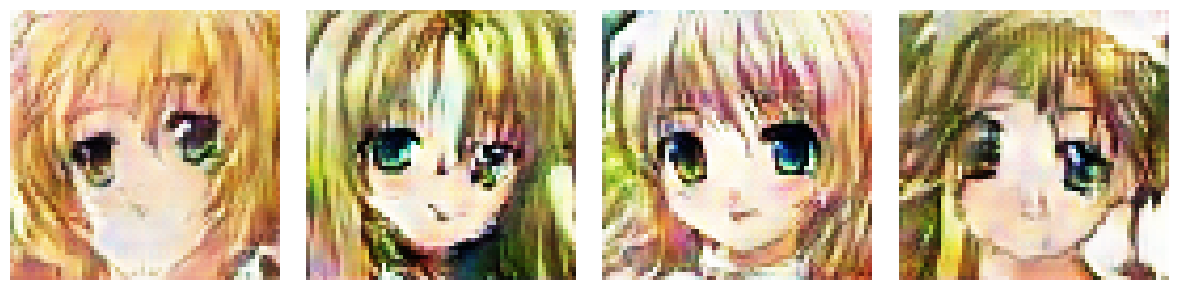

Epoch 100 | D loss: 0.1147 | D acc: 0.9659 | G loss: 5.7253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


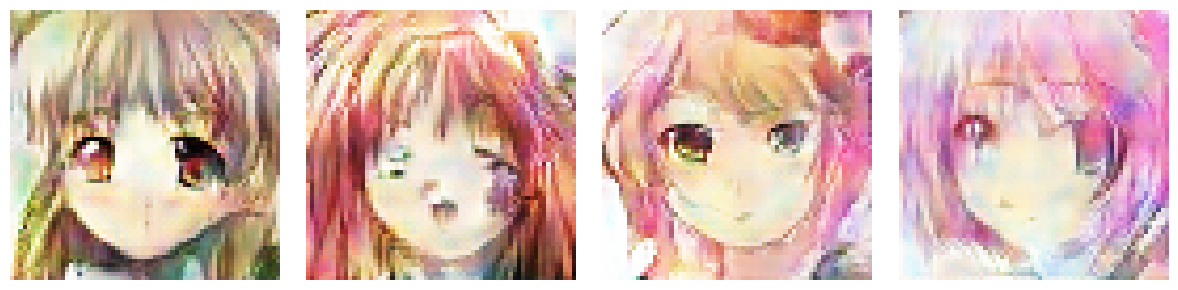

Epoch 200 | D loss: 0.0839 | D acc: 0.9739 | G loss: 5.9063
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


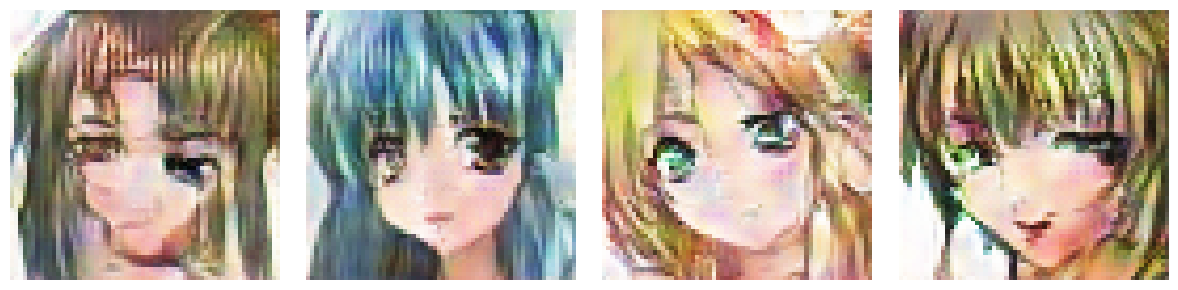

KeyboardInterrupt: 

In [12]:
epochs = 10000

# Bucle de entrenamiento
for epoch in range(epochs):
    # === Entrenar discriminador ===
    # 1. Obtener imágenes reales del generador
    real_images = next(train_generator)[0]

    # 2. Generar imágenes falsas
    z = generateLatentDim()
    fake_images = generator.predict(z, verbose=0)

    # 3. Crear etiquetas: 1 para reales, 0 para falsas
    real_labels = np.ones((real_images.shape[0], 1))
    fake_labels = np.zeros((fake_images.shape[0], 1))

    # 4. Combinar y mezclar
    combined_images = np.concatenate([real_images, fake_images], axis=0)
    combined_labels = np.concatenate([real_labels, fake_labels], axis=0)

    indices = np.arange(combined_images.shape[0])
    np.random.shuffle(indices)

    shuffled_images = combined_images[indices]
    shuffled_labels = combined_labels[indices]

    # 5. Entrenar discriminador con batch mezclado
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(shuffled_images, shuffled_labels)

    # === Entrenar generador ===
    z = generateLatentDim()
    trick_labels = np.ones((batch_size, 1))  # queremos que el discriminador crea que son reales
    discriminator.trainable = False
    g_loss = gan.train_on_batch(z, trick_labels)

    # Mostrar progreso
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D loss: {d_loss[0]:.4f} | D acc: {d_loss[1]:.4f} | G loss: {g_loss:.4f}")
        mostrar_imagenes_generadas(generator)


### Comprobar resultados

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


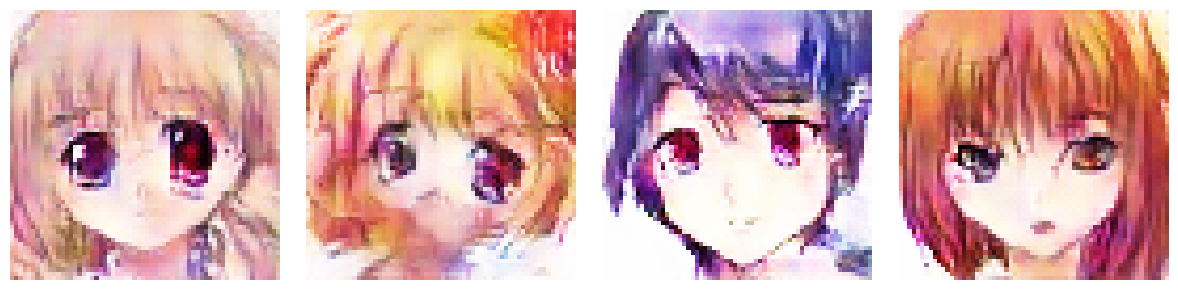

In [25]:
mostrar_imagenes_generadas(generator)

In [ ]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)
os.makedirs("models/"+timestamp, exist_ok=True)
generator_path = f"models/{timestamp}/Generator.keras"
discriminator_path = f"models/{timestamp}/Discrimiator.keras"

# Save the model
generator.save(generator_path)
discriminator.save(discriminator_path)

In [20]:
def guardar_imagenes_en_csv(imagenes_grises):
    """
    Guarda imágenes en escala de grises en un CSV con columnas: id, 0, ..., 4095.

    Args:
        imagenes_grises: array de forma (200, 64, 64) con imágenes en escala de grises.
        nombre_csv: nombre del archivo CSV a guardar.
    """
    num_imagenes = imagenes_grises.shape[0]
    pixeles_por_imagen = imagenes_grises.shape[1] * imagenes_grises.shape[2]

    # Aplanar cada imagen a un vector de 4096 elementos
    imagenes_aplanadas = imagenes_grises.reshape(num_imagenes, pixeles_por_imagen)

    # Crear DataFrame con columnas: id, 0, ..., 4095
    columnas = ['id'] + [str(i) for i in range(pixeles_por_imagen)]
    datos = np.column_stack((np.arange(1, num_imagenes + 1), imagenes_aplanadas))
    df = pd.DataFrame(datos, columns=columnas)

    # Guardar en CSV
    os.makedirs("submissions", exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
    df.to_csv("submissions/GAN_"+timestamp+".csv", index=False)


guardar_imagenes_en_csv(generar_imagenes(generator, num_imagenes=200))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
